In [ ]:
import sys
from ri_ssim import micro_SSIM
from ri_ssim.CARE_normalization import normalize_CARE, normalize_minmse
from disentangle.core.tiff_reader import load_tiff
import matplotlib.pyplot as plt
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from ri_ssim.ri_ssim import mse_based_range_invariant_structural_similarity
from disentangle.analysis.plot_utils import add_pixel_kde, clean_ax, add_subplot_axes, add_text
import os
from matplotlib import patches

def add_text(ax, text, img_shape, place='TOP_LEFT', edgecolor='black'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(img_shape[1] * 15 / 500, img_shape[0] * 55 / 500, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.9))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 500, s1 - s1 * 35 / 500, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.9))



In [54]:
# gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-31.tif'
# pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-31.tif'
# noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/actin-60x-noise2-lowsnr.tif'

# gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-29.tif'
# pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-29.tif'
# noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/mito-60x-noise2-lowsnr.tif'

# denoiSplit
# gt_path = '/group/jug/ashesh/downloads/Actin_HighSNR.tif'
# pred_path = '/group/jug/ashesh/downloads/Actin_pred.tif'
# noisy_gt_path = gt_path

gt_path = '/group/jug/ashesh/downloads/Mito_HighSNR.tif'
pred_path = '/group/jug/ashesh/downloads/Mito_pred.tif'
noisy_gt_path = gt_path

In [55]:
debug_mode = True
gt = load_tiff(gt_path)
pred = load_tiff(pred_path)
gt_lowsnr = load_tiff(noisy_gt_path)
BACKGROUND_PERCENTILE = 3
BACKGROUND_OFFSET_PREDICTION = np.percentile(pred, BACKGROUND_PERCENTILE, keepdims=False)
BACKGROUND_OFFSET_TARGET = np.percentile(gt, BACKGROUND_PERCENTILE, keepdims=False)
print(f'Background offset for prediction: {BACKGROUND_OFFSET_PREDICTION}')
print(f'Background offset for target: {BACKGROUND_OFFSET_TARGET}')

Background offset for prediction: 102.39199
Background offset for target: 102.0


In [56]:
from dataclasses import dataclass

@dataclass
class MaxNormalizer:
    factor: float

    def normalize(self, data):
        return data / self.factor


def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

def get_zoomin_hw(img, zoomin_size=80):
    hw = None
    hw_std = None
    for _ in range(200):
        h = np.random.randint(0, img.shape[0]-zoomin_size)
        w = np.random.randint(0, img.shape[1]-zoomin_size)
        if hw is None:
            hw = [h,w]
            hw_std = img[h:h+80,w:w+80].std()
        else:
            cur_std = img[h:h+80,w:w+80].std()
            if cur_std  > hw_std:
                hw = [h,w]
                hw_std = cur_std
    return hw

def _normalize_random(rand_img):
    rand_img = (rand_img - rand_img.mean())/rand_img.std()
    return rand_img

## Obtain dataset level scaling factor

In [57]:
from ri_ssim.ri_ssim import get_transformation_params
def microSSIM_pred_norm(data):
    data = data - BACKGROUND_OFFSET_PREDICTION
    return data

def microSSIM_gt_norm(data):
    data = data - BACKGROUND_OFFSET_TARGET
    return data


gt_all_norm = microSSIM_gt_norm(gt)
pred_all_norm = microSSIM_pred_norm(pred)
all_max = gt_all_norm.max()
normalizer = MaxNormalizer(all_max)

MICROSSIM_SCALE = get_transformation_params(gt_all_norm[:], pred_all_norm[:])
MICROSSIM_SCALE

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


22.448359062967576

### Multiple ways of data normalization.

In [13]:
idx = 0#np.random.randint(0, gt.shape[0])
print(idx)

# Without any normalization. 
gt_tmp = gt[idx]
pred_tmp = pred[idx]

# mean, std based normalization
gt_norm_meanstd = (gt_tmp - gt_tmp.mean())/gt_tmp.std()
pred_norm_meanstd = (pred_tmp - pred_tmp.mean())/pred_tmp.std()

# CARE based normalization
gt_norm_CARE = normalize_CARE(gt_tmp.copy())
pred_norm_CARE = normalize_minmse(pred_tmp.copy(), gt_norm_CARE)

# microssim normalization
pred_norm_microssim = microSSIM_pred_norm(pred_tmp.copy())
gt_norm_microssim = microSSIM_gt_norm(gt_tmp.copy())

# Background + max normalization == microsim normalization
# gt_norm_microssim = normalizer.normalize(gt_norm_bkg)
# pred_norm_microssim = normalizer.normalize(pred_norm_bkg)

0


In [14]:
ssim_dict = micro_SSIM(gt_tmp , pred_tmp, ri_factor=1.0, 
                       data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

ssim_dict_meanstd_normalized = micro_SSIM(gt_norm_meanstd , 
                     pred_norm_meanstd, 
                     ri_factor=1.0,  
                     data_range=gt_norm_meanstd.max() - gt_norm_meanstd.min(), return_individual_components=True)

CAREssim_carenorm_dict = micro_SSIM(gt_norm_CARE , pred_norm_CARE, 
                                    ri_factor=1.0,
                                    data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)

microssim_dict = micro_SSIM(gt_norm_microssim , pred_norm_microssim, 
                            ri_factor=MICROSSIM_SCALE,
                            data_range=gt_norm_microssim.max() - gt_norm_microssim.min(), return_individual_components=True)

/home/ashesh.ashesh/code/RI-SSIM/ri_ssim/ri_ssim.py:60: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(vx * vy) + C2


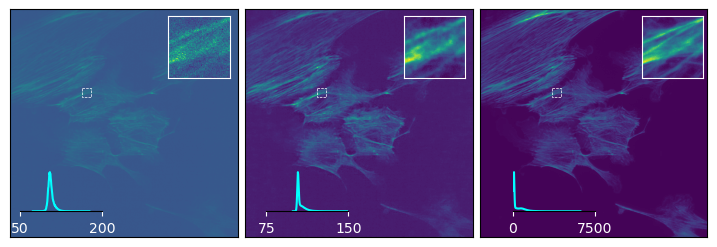

In [8]:
zoomin_sz = 80
save_to_file = False and not debug_mode



_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = get_zoomin_hw(gt[idx])
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 4 #if save_to_file else 4

add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

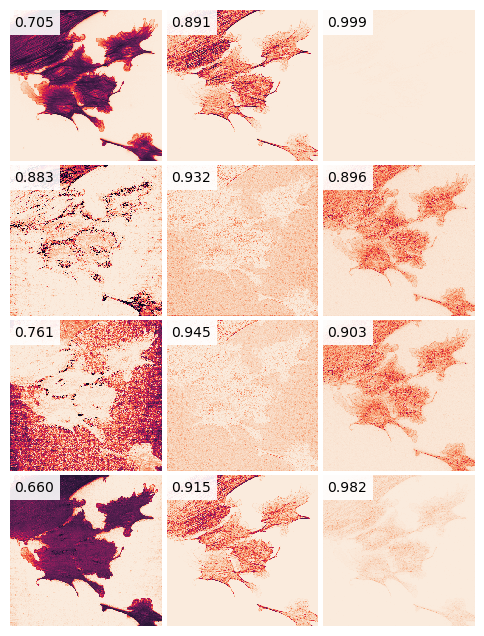

In [9]:
fac = 2 if save_to_file else 4
shape = ssim_dict['luminance'].shape
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3,img_sz*4), ncols=3,nrows=4)

# SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(ssim_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
    val = f"{ssim_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# SSIM NORMALIZED
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(ssim_dict_meanstd_normalized[key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
    val = f"{ssim_dict_meanstd_normalized[key][::fac,::fac].mean():.3f}"
    add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# CARE-SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(CAREssim_carenorm_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[2,i], cbar=False)
    val = f"{CAREssim_carenorm_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[2,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# MICRO-SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(microssim_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[3,i], cbar=False)
    val = f"{microssim_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[3,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'baseline_comparison_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [10]:
from skimage.metrics import structural_similarity as ssim
# CAREssim_carenorm_dict = micro_SSIM(gt_norm_CARE , pred_norm_CARE, ri_factor=1.0, gaussian_weights=True, data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)



In [11]:
# idx =0 
# gt_tmp = gt[idx]
# pred_tmp = pred[idx]
# gt_tmp = normalizer.normalize(remove_background(gt[idx]))
# pred_tmp = normalizer.normalize(remove_background(pred[idx]))
# # gt_tmp = normalizer.normalize(gt[idx])
# # gt_tmp = gt_tmp - gt_tmp.mean()
# # pred_tmp = normalizer.normalize(pred[idx])
# # pred_tmp = pred_tmp - pred_tmp.mean()
# ssim_comp_dict = micro_SSIM(gt_tmp, pred_tmp, ri_factor=None, 
#                                     data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
# ssim_comp_dict['alpha'].mean(), ssim_comp_dict['SSIM'].mean(), ssim_comp_dict['luminance'].mean(), ssim_comp_dict['contrast'].mean(), ssim_comp_dict['structure'].mean()

## Inspecting background removal

In [12]:
def _normalize_bkg_ablation(remove_bkg, img, remove_bkg_fn):
    img_tmp = None
    if isinstance(remove_bkg, bool):
        img_tmp =remove_bkg_fn(img) if remove_bkg else img
    elif remove_bkg == 'mean':
        img_tmp = img - img.mean()
    return img_tmp

idx_list  = list(range(0,100,10))
dicts = defaultdict(list)
for idx in tqdm(idx_list):
    for remove_bkg in [True, False, 'mean']:
        gt_tmp = _normalize_bkg_ablation(remove_bkg, gt[idx], microSSIM_gt_norm)
        gt_tmp_lowsnr = _normalize_bkg_ablation(remove_bkg, gt_lowsnr[idx], microSSIM_pred_norm)
        pred_tmp = _normalize_bkg_ablation(remove_bkg, pred[idx], microSSIM_pred_norm)
        
        ssim_comp_dict = micro_SSIM(gt_tmp, pred_tmp, ri_factor=None, 
                                    data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        dicts[remove_bkg].append(ssim_comp_dict)
        assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-5

  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

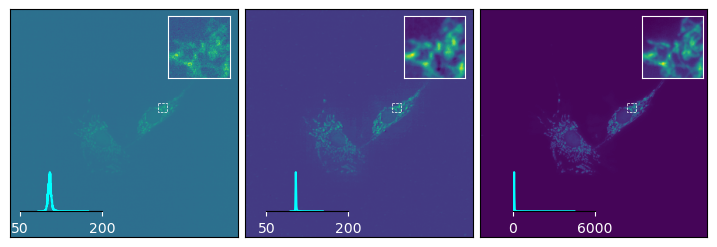

In [13]:

def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

save_to_file = False and not debug_mode
ith_img= 8

idx = idx_list[ith_img]
zoomin_hw = get_zoomin_hw(gt[idx])#[(700, 750), (1150, 750), (750, 450), (500, 500)][ith_img]
_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = zoomin_hw
zoomin_sz = 80
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 2 if save_to_file else 4
add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])


add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

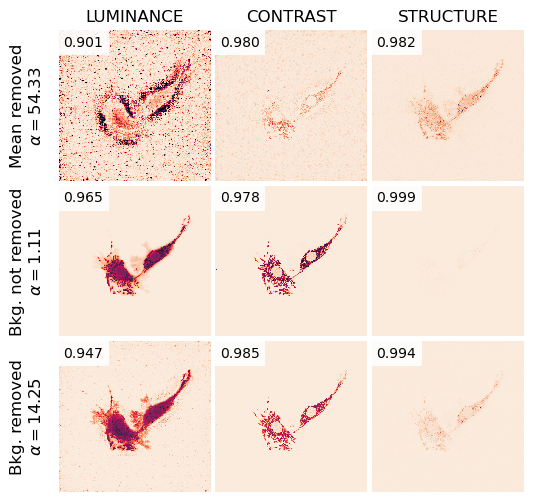

In [14]:
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import os

shape = list(dicts[True][0]['luminance'].shape)
fac = 2 if save_to_file else 4
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3,img_sz*3),ncols=3,nrows=3)

# for idx in range(num_samples):
# For True
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts[True][ith_img][key][::fac,::fac],vmin=0,vmax=1,ax=ax[2, i], cbar=False)
    val = f"{dicts[True][ith_img][key][::fac,::fac].mean():.3f}"
    add_text(ax[2, i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# For False
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts[False][ith_img][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1, i], cbar=False)
    val = f"{dicts[False][ith_img][key][::fac,::fac].mean():.3f}"
    add_text(ax[1, i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# For mean
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts['mean'][ith_img][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0, i], cbar=False)
    val = f"{dicts['mean'][ith_img][key][::fac,::fac].mean():.3f}"
    add_text(ax[0, i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')



    ax[0, 0].set_title('Luminance'.upper())
    ax[0, 1].set_title('Contrast'.upper())
    ax[0, 2].set_title('Structure'.upper())


clean_ax(ax)


alpha_true = round(dicts[True][ith_img]['alpha'],2)
ax[2,0].set_ylabel(f'Bkg. removed\n$\\alpha={alpha_true}$', fontsize=12)

alpha_false = round(dicts[False][ith_img]['alpha'],2)
ax[1,0].set_ylabel(f'Bkg. not removed\n$\\alpha={alpha_false}$', fontsize=12)

alpha_mean = round(dicts['mean'][ith_img]['alpha'],2)
ax[0,0].set_ylabel(f'Mean removed\n$\\alpha={alpha_mean}$', fontsize=12)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)


In [ ]:
# import seaborn as sns
# from disentangle.analysis.plot_utils import clean_ax
# import os
# idx = idx_list[0]

# shape = list(dicts[True][idx]['luminance'].shape)
# fac = 1 if save_to_file else 4
# img_sz = 2
# _,ax = plt.subplots(figsize=(img_sz*3,img_sz*2),ncols=3,nrows=2)

# # For True
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[True][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
#     val = f"{dicts[True][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# # For False
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[False][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
#     val = f"{dicts[False][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')


# clean_ax(ax)
# ax[0,0].set_title('Luminance'.upper())
# ax[0,1].set_title('Contrast'.upper())
# ax[0,2].set_title('Structure'.upper())

# alpha_true = round(dicts[True][idx]['alpha'],2)
# ax[0,0].set_ylabel('Bkg removed,  ' + f'$\\alpha=${alpha_true}', fontsize=12)

# alpha_false = round(dicts[False][idx]['alpha'],2)
# ax[1,0].set_ylabel('Bkg not removed,  ' + f'$\\alpha=${alpha_false}', fontsize=12)

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# if save_to_file:
#     postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'bkg_ablation_Idx{idx}_{postfix}'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)


### Inspecting background on differently intense pixels

In [ ]:
# q_list = [0.01, 0.1, 0.5, 0.9,0.95]
# imgsz = 2
# _,ax = plt.subplots(figsize=(imgsz * len(q_list), imgsz), ncols=len(q_list))
# padx = pady = None
# for ax_idx, q_ in enumerate(q_list):
#     q_val = np.quantile(gt[idx], q_)
#     mask = gt[idx] > q_val
#     ax[ax_idx].imshow(mask)
#     if padx is None:
#         padx, pady = (np.array(mask.shape) - np.array(dicts[True][0]['SSIM'].shape) )//2

#     mask = mask[pady:-pady,padx:-padx]
    
#     ssim_true = 0
#     ssim_false = 0
#     for idx in range(len(dicts[True])):
#         ssim_true += dicts[True][idx]['SSIM'][mask].mean()
#         ssim_false += dicts[False][idx]['SSIM'][mask].mean()
    
#     ssim_true /= len(dicts[True])
#     ssim_false /= len(dicts[False])
#     print(q_,q_val, ssim_true, ssim_false)

# clean_ax(ax)

## Background levels 

In [ ]:
# from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict, _get_ri_factor
# q_min = 0.1
# idx = np.random.choice(len(gt))
# gt_cur = gt[idx] - np.quantile(gt[idx], q_min)
# pred_cur = pred[idx] - np.quantile(pred[idx], q_min)
# gt_cur[gt_cur < 0] = 0
# pred_cur[pred_cur < 0] = 0

# ssim_dict = structural_similarity_dict(
#     gt_cur,
#     pred_cur,
#     data_range=gt_cur.max() - gt_cur.min())

# ri_factor = _get_ri_factor(ssim_dict)
# ux, uy, vx, vy, vxy, C1, C2 = (
#     ssim_dict["ux"],
#     ssim_dict["uy"],
#     ssim_dict["vx"],
#     ssim_dict["vy"],
#     ssim_dict["vxy"],
#     ssim_dict["C1"],
#     ssim_dict["C2"],
# )
# raw_dict = _ssim_from_params(
#     ri_factor,
#     ux,
#     uy,
#     vx,
#     vy,
#     vxy,
#     C1,
#     C2,
#     return_individual_components=True,
# )

# q_vals = np.quantile(gt_tmp, [0,0.01,0.05,0.1,0.9, 0.95, 0.99])
# for qv in q_vals:
#     mask = gt_cur > np.quantile(gt_cur, qv)


# Manual varying of alpha: inspecting its uniqueness

In [15]:
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict
save_to_file = False and not debug_mode

ssim_components = defaultdict(list)
idx_list = []
alpha_list = np.concatenate([np.arange(0,300,1)])
num_idx = 5
for idx in np.random.choice(len(gt), size=num_idx, replace=False):
    idx_list.append(idx)
    gt_cur = microSSIM_gt_norm(gt[idx])
    pred_cur = microSSIM_pred_norm(pred[idx])


    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_cur,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
    
    ssim_components['ssim'].append(ssim_arr)    

 32%|███▏      | 95/300 [00:05<00:11, 17.54it/s]


KeyboardInterrupt: 

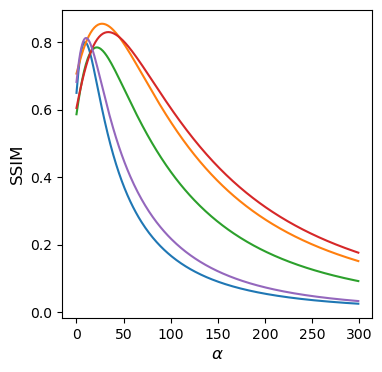

In [19]:
import pandas as pd
_,ax = plt.subplots(figsize=(4,4))
pd.DataFrame(np.stack(ssim_components['ssim']).T, index=alpha_list).plot(legend=False, ax=ax)
ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('SSIM', fontsize=12)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_uniqueness_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


# Manual varying of alpha: inspecting the components
Here, we look at 
1. random 
2. flipped. 
3. normal prediction

In [ ]:
# from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
# from tqdm import tqdm
# import numpy as np
# from collections import defaultdict

# gt_cur = microSSIM_normalization(gt[idx])
# pred_cur = microSSIM_normalization(pred[idx])
# random_pred = np.random.rand(*gt_cur.shape)
# random_pred = random_pred - random_pred.min()

# pred_list = [pred_cur, pred_cur[::-1], pred_cur[:,::-1], pred_cur[::-1,::-1], random_pred]
# # alpha_list = np.concatenate([np.arange(0.03,20,0.03),np.arange(20,100,0.1), np.arange(100,300,1), np.arange(300,1000,3)])
# alpha_list = np.concatenate([np.arange(0.03,100,0.4)])
# ssim_components = defaultdict(list)

# for pred_tmp in pred_list:
#     ssim_dict = structural_similarity_dict(
#         gt_cur,
#         pred_tmp,
#         data_range=gt_cur.max() - gt_cur.min())

#     ux, uy, vx, vy, vxy, C1, C2 = (
#         ssim_dict["ux"],
#         ssim_dict["uy"],
#         ssim_dict["vx"],
#         ssim_dict["vy"],
#         ssim_dict["vxy"],
#         ssim_dict["C1"],
#         ssim_dict["C2"],
#     )

#     ssim_arr = []
#     luminance_arr = []
#     contrast_arr = []
#     structure_arr = []
#     for factor in tqdm(alpha_list):
#         ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
#         ssim_arr.append(ssim_dict['SSIM'].mean())
#         luminance_arr.append(ssim_dict['luminance'].mean())
#         contrast_arr.append(ssim_dict['contrast'].mean())
#         structure_arr.append(ssim_dict['structure'].mean())
    
#     ssim_components['ssim'].append(ssim_arr)
#     ssim_components['luminance'].append(luminance_arr)
#     ssim_components['contrast'].append(contrast_arr)
#     ssim_components['structure'].append(structure_arr)
    

In [ ]:
# import pandas as pd
# import os
# save_to_file = True and not debug_mode

# _,ax = plt.subplots(figsize=(16,4),ncols=4)
# for i, key in enumerate(['ssim','luminance','contrast','structure']):
#     df = pd.DataFrame(np.stack(ssim_components[key]).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
#     df.plot(fontsize=12, ax=ax[i]).legend(loc='upper right', fontsize=12)
#     ax[i].set_title(key.upper(), fontsize=12)

# for i in range(4):
#     ax[i].set_xlabel('$\\alpha$', fontsize=12)
#     ax[i].set_ylabel('SSIM', fontsize=12)

# if save_to_file:
#     postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'ssim_components_Idx{idx}_{postfix}'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)

## Experiment to observe saturation factor.
1. we want to just show the perofmance on the random test image. and we want to show the performance on the original prediction.
2. we can show a table with SSIM and its 3 components. 
3. We can also show the coefficients vs the components, in both numerator and denominator.

It will be amazing to show the predicted image and the random noise image as well. it will be a pretty convincing figure. 

In [26]:
def luminance_without_C1(alpha, ux, uy):
    num = 2 * alpha * ux * uy
    den = ux**2 + (alpha**2) * uy**2
    return num, den

def contrast_without_C2(alpha, vx, vy):
    num = 2 * alpha * np.sqrt(vx * vy)
    den = vx + (alpha**2) * vy
    return num, den

def structure_without_C2(alpha, vx, vy, vxy):
    num = 2 * alpha * vxy
    den = 2 * alpha * np.sqrt(vx * vy + 1e-10)
    return num, den


def get_multiplicative_factor_to_C(ssim_dict):
    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )
    alpha = ssim_dict['alpha']
    num_luminance, den_luminance = luminance_without_C1(alpha, ux, uy)
    num_contrast, den_contrast = contrast_without_C2(alpha, vx, vy)
    num_structure, den_structure = structure_without_C2(alpha, vx, vy, vxy)

    # luminance_factors = (C1/num_luminance.mean(), C1/den_luminance.mean())
    # contrast_factors = (C2/num_contrast.mean(), C2/den_contrast.mean())
    # structure_factors = (C2/num_structure.mean(), C2/den_structure.mean())
    luminance_factors = np.minimum(np.abs(C1/num_luminance), np.abs(C1/den_luminance)).mean()
    contrast_factors = np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast)).mean()
    structure_factors = np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure)).mean()
    return luminance_factors, contrast_factors, structure_factors


In [14]:
# pred_std = np.mean([pred[i].std() for i in range(100)])
# pred_mean = np.mean([pred[i].mean() for i in range(100)])


In [15]:
def _saturation_ablation_normalization(norm_mode, img, bkg_remove_fn):
    if norm_mode in ['microSSIM', 'no_downscale']:
        img_out = bkg_remove_fn(img)
    elif norm_mode == 'downscale':
        img_out = normalizer.normalize(bkg_remove_fn(img))
    elif norm_mode == 'no_bkg_rmv':
        img_out = img
    else:
        raise ValueError(f'Invalid value for norm_mode: {norm_mode}')
    return img_out

In [16]:
correct_pred_factorsdict = defaultdict(lambda: defaultdict(list))
random_pred_factorsdict = defaultdict(lambda: defaultdict(list))#defaultdict(list)
nsamples =50
for norm_mode in ['no_bkg_rmv','no_pred_bkg_rmv', 'no_downscale', 'downscale', 'microSSIM']:
    for idx in tqdm(range(nsamples)):
        gt_norm_mode = norm_mode
        if norm_mode == 'no_pred_bkg_rmv':
            gt_norm_mode = 'no_downscale'
        
        gt_tmp = _saturation_ablation_normalization(gt_norm_mode, gt[idx], microSSIM_gt_norm)
        pred_tmp = _saturation_ablation_normalization(norm_mode, pred[idx], microSSIM_pred_norm) if norm_mode != 'no_pred_bkg_rmv' else pred[idx]
        ssim_dict = micro_SSIM(gt_tmp , pred_tmp, 
                                ri_factor=MICROSSIM_SCALE if norm_mode=='microSSIM' else 1.0,
                                data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict)
        
        correct_pred_factorsdict[norm_mode]['luminance'].append(luminance_factors)
        correct_pred_factorsdict[norm_mode]['contrast'].append(contrast_factors)
        correct_pred_factorsdict[norm_mode]['structure'].append(structure_factors)
        correct_pred_factorsdict[norm_mode]['SSIM'].append(ssim_dict['SSIM'].mean())


    for idx in tqdm(range(nsamples)):
        gt_tmp = _saturation_ablation_normalization(gt_norm_mode, gt[idx], microSSIM_gt_norm)
        rand_raw = np.random.rand(*gt_tmp.shape)
        # pred_tmp = _normalize_random(rand_raw)
        # pred_tmp= (pred_tmp - pred_tmp.mean())/pred_tmp.std()
        # # pred_tmp = pred_tmp * pred[0].std() + pred[0].mean()
        # pred_tmp = pred_tmp * pred_std + pred_mean

        # pred_tmp = microSSIM_normalization(pred_tmp)
        pred_tmp = _saturation_ablation_normalization(norm_mode, rand_raw, microSSIM_pred_norm) if norm_mode != 'no_pred_bkg_rmv' else rand_raw

        ssim_dict = micro_SSIM(gt_tmp , pred_tmp, 
                                ri_factor=MICROSSIM_SCALE if norm_mode=='microSSIM' else 1.0,
                                data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict)
        
        random_pred_factorsdict[norm_mode]['luminance'].append(luminance_factors)
        random_pred_factorsdict[norm_mode]['contrast'].append(contrast_factors)
        random_pred_factorsdict[norm_mode]['structure'].append(structure_factors)
        random_pred_factorsdict[norm_mode]['SSIM'].append(ssim_dict['SSIM'].mean())



100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


/group/jug/ashesh/ri_ssim/images/ablation_downscaling_sample_input_N2V-2402-31.png


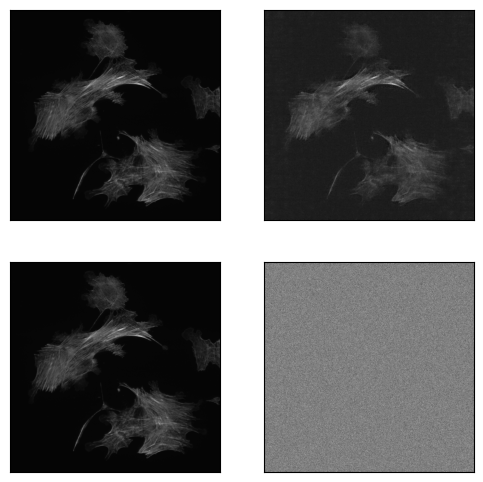

In [19]:
save_to_file = True #and not debug_mode
img_sz = 3
idx_tmp= 0
_,ax = plt.subplots(figsize=(img_sz*2,img_sz*2),ncols=2,nrows=2)
ax[0,0].imshow(gt[idx_tmp], cmap='gray')
ax[0,1].imshow(pred[idx_tmp], cmap='gray')
ax[1,0].imshow(gt[idx_tmp], cmap='gray')
ax[1,1].imshow(np.random.rand(*gt_tmp.shape), cmap='gray')
clean_ax(ax)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_downscaling_sample_input_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

/group/jug/ashesh/ri_ssim/images/ablation_downscaling_mode-downscale_N2V-2402-31.png


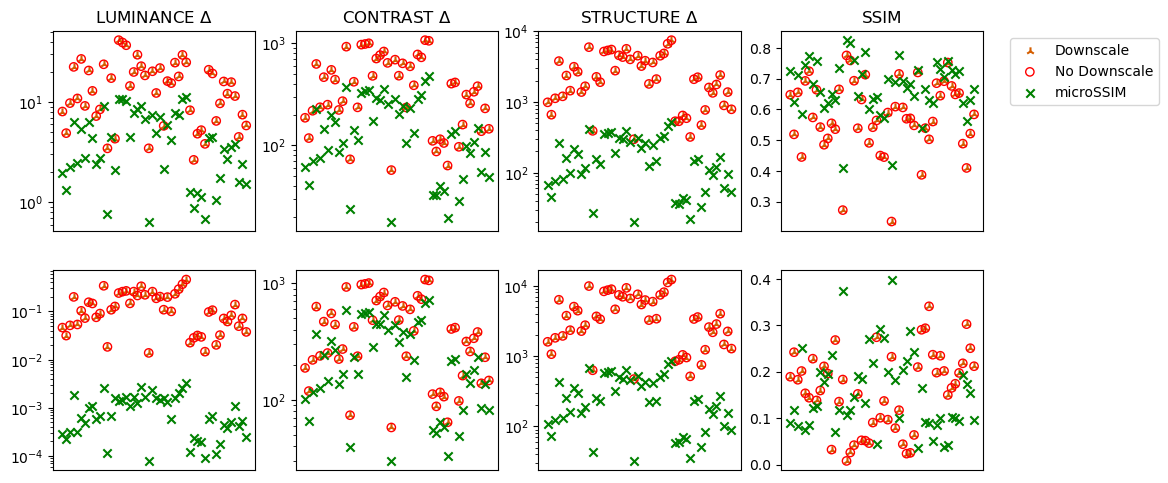

In [22]:
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
mode = 'downscale'
assert mode in ['background', 'downscale']
_,ax = plt.subplots(figsize=(4*img_sz,1.9*img_sz),ncols=4,nrows=2)
for col_ix, key in enumerate(['luminance', 'contrast', 'structure', 'SSIM']):
    if mode == 'background':
        # no bkg removal
        df = pd.DataFrame(correct_pred_factorsdict['no_bkg_rmv'][key]).abs().min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='With Bkg.', color='#0072B2', marker='h', facecolors='none')
        df = pd.DataFrame(random_pred_factorsdict['no_bkg_rmv'][key]).abs().min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='With Bkg.', color='#0072B2', marker='h', facecolors='none')

        # no pred bkg removal
        df = pd.DataFrame(correct_pred_factorsdict['no_pred_bkg_rmv'][key]).abs().min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='No Pred. Bkg.', color='#D55E00', marker='x',)
        df = pd.DataFrame(random_pred_factorsdict['no_pred_bkg_rmv'][key]).abs().min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='No Pred. Bkg.', color='#D55E00', marker='x',)
    
    elif mode == 'downscale':
        df = pd.DataFrame(correct_pred_factorsdict['downscale'][key]).abs().min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='Downscale', color='#D55E00', marker = '2')
        df = pd.DataFrame(random_pred_factorsdict['downscale'][key]).abs().min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='Downscale', color='#D55E00', marker = '2')

        df = pd.DataFrame(correct_pred_factorsdict['no_downscale'][key]).abs().min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='No Downscale', color='red', facecolors='none')
        df = pd.DataFrame(random_pred_factorsdict['no_downscale'][key]).abs().min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='No Downscale', color='red', facecolors='none')


    # microSSIM
    df = pd.DataFrame(correct_pred_factorsdict['microSSIM'][key]).abs().min(axis=1)
    ax[0,col_ix].scatter(df.index, df.values, label='microSSIM', color='green', marker='x')
    df = pd.DataFrame(random_pred_factorsdict['microSSIM'][key]).abs().min(axis=1)
    ax[1,col_ix].scatter(df.index, df.values, label='microSSIM', color='green', marker='x')

    if key != 'SSIM':
        ax[0,col_ix].set_title(key.upper() + f' $\\Delta$', fontsize=12)
    else:
        ax[0,col_ix].set_title(key.upper(), fontsize=12)

    if key != 'SSIM':
        ax[0,col_ix].set_yscale('log')
        ax[1,col_ix].set_yscale('log')
 
# handles, labels = ax[0,0].get_legend_handles_labels()
# order = [1,0,2]
# ax[0,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', fontsize=10)
# ax[0,3].legend(loc='lower right', fontsize=10)
ax[0,3].legend(bbox_to_anchor=(1.1,1.0))
for i in range(2):
    for j in range(4):
        ax[i,j].tick_params(axis='x',which='both',bottom=False, top=False,labelbottom=False) 

# ax[0,0].legend(loc='upper left', fontsize=10)
# plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_downscaling_mode-{mode}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

## Experiment on how the offset plays a role in performance

In [ ]:
import numpy as np
from tqdm import tqdm
idx = np.random.randint(0,len(gt))
enable_ri = False
gt_cur = microSSIM_normalization(gt[idx])
pred_cur = microSSIM_normalization(pred[idx])
ssim_arr = []
lum_arr = []
con_arr = []
str_arr = []
offset_arr = list(np.arange(-0.1,0.1,0.01))
for offset in tqdm(offset_arr):
    ssim_dict = micro_SSIM(gt_cur + offset , 
                           pred_cur + offset, 
                           ri_factor=scaling_factor if enable_ri else 1.0, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)
    ssim_arr.append(ssim_dict['SSIM'].mean())
    lum_arr.append(ssim_dict['luminance'].mean())
    con_arr.append(ssim_dict['contrast'].mean())
    str_arr.append(ssim_dict['structure'].mean())

  0%|          | 0/20 [00:00<?, ?it/s]/home/ashesh.ashesh/code/RI-SSIM/ri_ssim/ri_ssim.py:60: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(vx * vy) + C2
100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


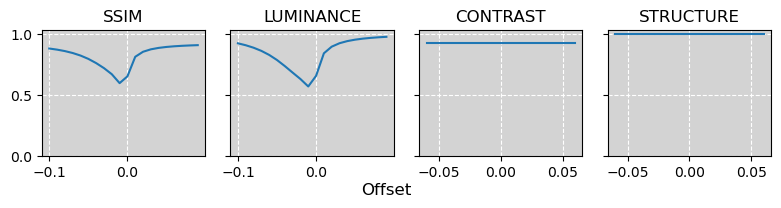

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd

save_to_file = False and not debug_mode

fig,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].plot(offset_arr,ssim_arr)
ax[1].plot(offset_arr,lum_arr)
ax[2].plot(offset_arr,con_arr)
ax[3].plot(offset_arr,str_arr)
# ax[3].set_yscale('log')
for ax_ in ax:
    # ax_.set_ylim([0.0,1.1])
    ax_.set_ylim([0,1.03])
    ax_.grid(visible=True, color='w', linestyle='--')
    ax_.set_facecolor('lightgrey')

for ax_ in ax[1:]:
    ax_.set_yticklabels([])


plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0].set_title('SSIM')
ax[1].set_title('LUMINANCE')
ax[2].set_title('CONTRAST')
ax[3].set_title('STRUCTURE')

fig.text(0.5, 0.0, 'Offset', ha='center', fontsize=12)
plt.tight_layout()

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)


/group/jug/ashesh/ri_ssim/images/synthetic_ablation_C1C2_relevance_plot.png


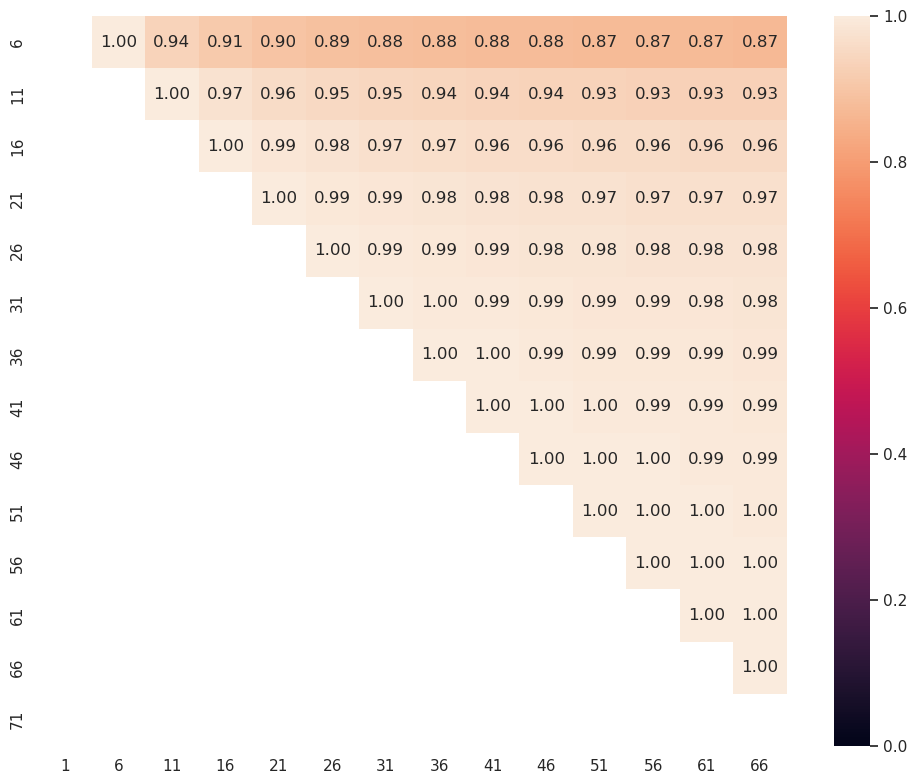

In [ ]:
def compute(numerator_factor, denominator_factor):
    if numerator_factor > denominator_factor:
        return np.nan
    return (1 + numerator_factor)/(1 + denominator_factor)


num_factor = np.arange(1, 75, 5)
den_factor = np.arange(1, 75, 5)
num_cor, den_cor = np.meshgrid(num_factor, den_factor)
shape = num_cor.shape
num_cor_fl = num_cor.flatten()
den_cor_fl = den_cor.flatten()
lum = np.array([compute(1/num_cor_fl[i], 1/den_cor_fl[i]) for i in range(num_cor_fl.shape[0])])
lum = lum.reshape(*shape)

# we skip the last numerator and first denominator
lum = lum[1:,:-1]
num_cor = num_cor[1:,:-1]
den_cor = den_cor[1:,:-1]
num_factor = num_factor[:-1]
den_factor = den_factor[1:]
mask = den_cor > num_cor

_, ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(lum,index=den_factor,columns=num_factor)
# tmp_df = df.loc[df.index[::2]][df.columns[::2]]
sns.heatmap(df, annot=True, mask=mask,vmin=0,vmax=1, fmt=".2f")
sns.set_theme(style='white')
if save_to_file:
    # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'synthetic_ablation_C1C2_relevance_plot.png'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


## Teaser Figure

### Problem

0.004814602
0.7285286
/group/jug/ashesh/ri_ssim/images/teaser_imagenet.png


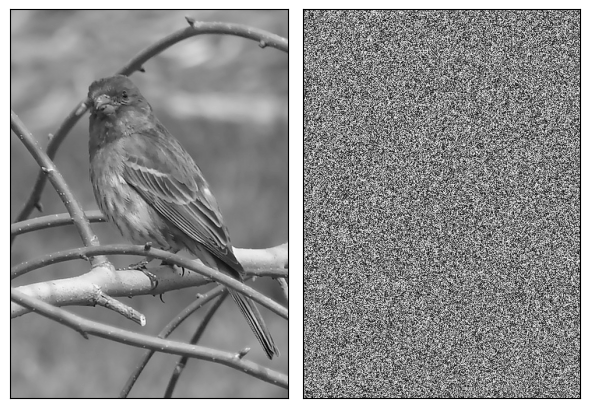

In [9]:
from PIL import Image
def _normalize_teaser(img):
    img = remove_background(img)
    # img = normalizer.normalize(img)
    return img

save_to_file = True and not debug_mode

img=np.array(Image.open('bird.jpeg').convert('L'))
_,ax = plt.subplots(figsize=(6,6),ncols=2)

ax[0].imshow(img,cmap='gray')


norm_img = _normalize_teaser(img)

rand_img = _normalize_random(np.random.rand(*img.shape))
ax[1].imshow(rand_img, cmap='gray')
print(micro_SSIM(norm_img, rand_img, ri_factor=1.0, 
                       data_range=norm_img.max() - norm_img.min()))


norm_gt = _normalize_teaser(gt[0])
rand_img = _normalize_random(np.random.rand(*gt[0].shape))
print(micro_SSIM(norm_gt, rand_img, ri_factor=1.0, 
                       data_range=norm_gt.max() - norm_gt.min()))

clean_ax(ax)
if save_to_file:
    # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'teaser_imagenet.png'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=100)



/group/jug/ashesh/ri_ssim/images/teaser_hagen.png


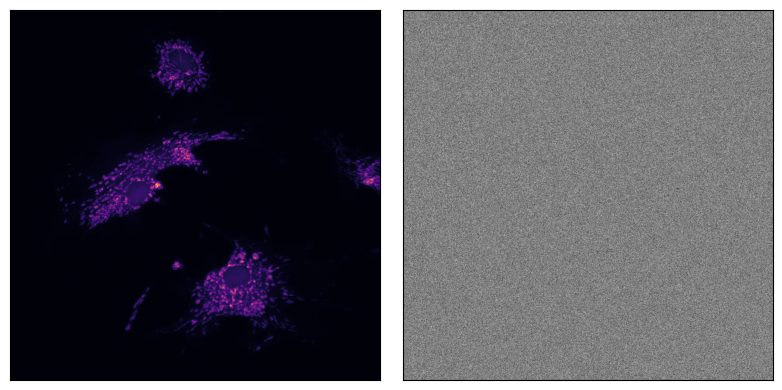

In [10]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(norm_gt,cmap='magma')
ax[1].imshow(rand_img, cmap='gray')
clean_ax(ax)
if save_to_file:
    # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'teaser_hagen.png'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=100)


In [ ]:
# num_samples = 30
# normal_pred_ssim = []
# rand_pred_ssim = []

# normal_pred_microssim = []
# rand_pred_microssim = []
# i_list = []
# for i in tqdm(np.random.choice(len(gt), num_samples, replace=False)):
#     gt_raw = gt[i]
#     gt_norm = _normalize_teaser(gt_raw)
#     pred_norm = _normalize_teaser(pred[i])
#     rand_raw = np.random.rand(*gt_norm.shape)
#     rand_norm = _normalize_random(rand_raw)
#     i_list.append(i)
#     normal_pred_ssim.append(micro_SSIM(gt_norm , pred_norm, ri_factor=1.0, 
#                        data_range=gt_norm.max() - gt_norm.min()))
#     rand_pred_ssim.append(micro_SSIM(gt_norm, rand_norm, ri_factor=1.0, data_range=gt_norm.max() - gt_norm.min()))
    

#     gt_norm = microSSIM_normalization(gt[i])
#     pred_norm = microSSIM_normalization(pred[i])
#     rand_norm = _normalize_random(rand_raw)
#     rand_norm= (rand_norm - rand_norm.mean())/rand_norm.std()
#     rand_norm = rand_norm * pred[0].std() + pred[0].mean()
#     # rand_norm = microSSIM_normalization(rand_norm)
#     rand_norm = microSSIM_normalization(rand_norm)
#     normal_pred_microssim.append(micro_SSIM(gt_norm , pred_norm, ri_factor=scaling_factor, data_range=gt_norm.max() - gt_norm.min()))
#     rand_pred_microssim.append(micro_SSIM(gt_norm , rand_norm, ri_factor=scaling_factor,data_range=gt_norm.max() - gt_norm.min()))


100%|██████████| 30/30 [01:13<00:00,  2.46s/it]


In [12]:
scaling_factor

19.90587412778534

In [10]:
# _,ax = plt.subplots(figsize=(4,4))
# mask = gt[0] > np.quantile(gt[0], 0.8)
# sns.kdeplot(remove_background(gt[0])[mask][::3].reshape(-1,), log_scale=False, ax=ax, label='high-SNR')
# # sns.kdeplot(remove_background(gt_lowsnr[0])[mask][::3].reshape(-1,), log_scale=False, ax=ax, label='low-SNR')
# sns.kdeplot(scaling_factor*remove_background(gt_lowsnr[0])[mask][::3].reshape(-1,), log_scale=False, ax=ax, label='microSSIM')
# plt.legend()
# # ax.set_yscale('log')

/group/jug/ashesh/ri_ssim/images/teaser_plot.png


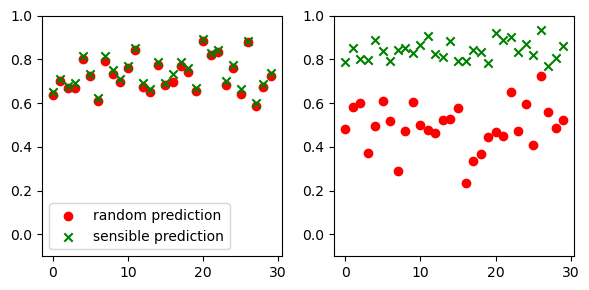

In [64]:
# save_to_file = True and not debug_mode
# _,ax = plt.subplots(figsize=(6,3), ncols=2)
# ax[0].scatter(np.arange(num_samples), rand_pred_ssim, label='random prediction', color='red')
# ax[0].scatter(np.arange(num_samples), normal_pred_ssim, label='sensible prediction', color='green', marker='x')
# ax[0].set_ylim([-0.1,1])


# ax[1].scatter(np.arange(num_samples), rand_pred_microssim, label='random prediction', color='red')
# ax[1].scatter(np.arange(num_samples), normal_pred_microssim, label='sensible prediction', color='green', marker='x')
# ax[1].set_ylim([-0.1,1])

# ax[0].legend(loc='lower left')
# if save_to_file:
#     # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'teaser_plot.png'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)



In [26]:
# _, ax = plt.subplots(figsize=(6,6))
# plt.imshow(pred[0], cmap='magma')
# clean_ax(ax)
# if save_to_file:
#     # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'teaser_plot_pred.png'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=100)


In [27]:
# _, ax = plt.subplots(figsize=(6,6))
# plt.imshow(np.random.rand(*gt[0].shape), cmap='magma')
# clean_ax(ax)
# if save_to_file:
#     # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'teaser_plot_random.png'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=100)


In [28]:
# qs = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# qs_nm = qs - qs.mean()
# alpha = 10
# qs_w = np.tanh(qs_nm * alpha) +1
# qs_w = qs_w/qs_w.sum()
# qs_w


array([2.46789152e-05, 1.82210239e-04, 1.33857018e-03, 9.48517464e-03,
       5.37882843e-02, 1.46211716e-01, 1.90514825e-01, 1.98661430e-01,
       1.99817790e-01, 1.99975321e-01])

In [46]:
# gt_tmp = gt[10]
# pred_tmp = pred[10]
# # pred_tmp = np.random.rand(*gt_tmp.shape)
# gt_norm = microSSIM_normalization(gt_tmp)
# ssim_dict = micro_SSIM( gt_norm , microSSIM_normalization(pred_tmp), ri_factor=None, data_range=gt_norm.max() - gt_norm.min(), return_individual_components=True)

In [47]:
# vals =np.quantile(gt_norm, list(qs) + [1])
# ssim_val =0
# for i in range(len(qs)):
#     mask = (gt_norm >= vals[i]) & (gt_norm < vals[i+1])
#     term = ssim_dict['SSIM'][mask[5:-5,5:-5]].mean()
#     print(qs[i], term)
#     ssim_val += term * qs_w[i]

# ssim_val

0.0 0.9310954
0.1 0.9364851
0.2 0.9404824
0.3 0.9435847
0.4 0.9463584
0.5 0.94849014
0.6 0.9381193
0.7 0.85343504
0.8 0.47000203
0.9 0.2376345


0.6896920062467146

In [58]:
def get_multiplicative_factor_to_C(ssim_dict):
    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )
    alpha = ssim_dict['alpha']
    num_luminance, den_luminance = luminance_without_C1(alpha, ux, uy)
    num_contrast, den_contrast = contrast_without_C2(alpha, vx, vy)
    num_structure, den_structure = structure_without_C2(alpha, vx, vy, vxy)

    # luminance_factors = (C1/num_luminance.mean(), C1/den_luminance.mean())
    # contrast_factors = (C2/num_contrast.mean(), C2/den_contrast.mean())
    # structure_factors = (C2/num_structure.mean(), C2/den_structure.mean())
    luminance_factors = np.nanmean(np.minimum(np.abs(C1/num_luminance), np.abs(C1/den_luminance)))
    contrast_factors = np.nanmean(np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast)))
    structure_factors = np.nanmean(np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure)))
    return luminance_factors, contrast_factors, structure_factors


In [59]:
from ri_ssim.rims_ssim import micro_MS_SSIM
correct_pred_factorsdict = defaultdict(list)
ssim = []
ms_ssim = []
for i in tqdm(range(len(gt))):
    gt_tmp = microSSIM_gt_norm(gt[i])
    pred_tmp = microSSIM_pred_norm(pred[i])
    ssim_dict = micro_SSIM(gt_tmp , pred_tmp, 
                            ri_factor=MICROSSIM_SCALE,
                            data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

    luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict)        
    correct_pred_factorsdict['luminance'].append(luminance_factors)
    correct_pred_factorsdict['contrast'].append(contrast_factors)
    correct_pred_factorsdict['structure'].append(structure_factors)
    ssim.append(ssim_dict['SSIM'].mean())
    msssim_val  = micro_MS_SSIM(gt_tmp , pred_tmp, ri_factor=MICROSSIM_SCALE, data_range=gt_tmp.max() - gt_tmp.min(), gaussian_weights=True)
    ms_ssim.append(msssim_val)



  0%|          | 0/10 [00:00<?, ?it/s]/home/ashesh.ashesh/code/RI-SSIM/ri_ssim/ri_ssim.py:60: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(vx * vy) + C2
/tmp/ipykernel_14801/3392966818.py:7: RuntimeWarning: invalid value encountered in sqrt
  num = 2 * alpha * np.sqrt(vx * vy)
/tmp/ipykernel_14801/3392966818.py:13: RuntimeWarning: invalid value encountered in sqrt
  den = 2 * alpha * np.sqrt(vx * vy + 1e-10)
/tmp/ipykernel_14801/1841403223.py:20: RuntimeWarning: divide by zero encountered in divide
  contrast_factors = np.nanmean(np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast)))
/tmp/ipykernel_14801/1841403223.py:21: RuntimeWarning: divide by zero encountered in divide
  structure_factors = np.nanmean(np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure)))
 40%|████      | 4/10 [00:11<00:18,  3.06s/it]/tmp/ipykernel_14801/1841403223.py:19: RuntimeWarning: divide by zero encountered in divide
  luminance_factors = np.nanmean(np.minim

In [60]:
def get_ssim_str(ssim_list):
    return f'{np.mean(ssim_list):.3f} +- {np.std(ssim_list):.3f}'

def get_saturation_str(saturation_dict):
    msg = f'l:{np.mean(saturation_dict["luminance"]):.1f}+-{np.std(saturation_dict["luminance"]):.1f} '
    msg += f'c:{np.mean(saturation_dict["contrast"]):.1f}+-{np.std(saturation_dict["contrast"]):.1f} '
    msg += f's:{np.mean(saturation_dict["structure"]):.1f}+-{np.std(saturation_dict["structure"]):.1f}'
    return msg

In [61]:
token = os.path.basename(gt_path).replace('gt-','').replace('.tif','')

print(token, 'SSIM', get_ssim_str(ssim))
print(token, 'MS-SSIM', get_ssim_str(ms_ssim))
print(token, 'Saturation', get_saturation_str(correct_pred_factorsdict))

Mito_HighSNR SSIM 0.810 +- 0.059
Mito_HighSNR MS-SSIM 0.899 +- 0.038
Mito_HighSNR Saturation l:10.7+-11.0 c:804.4+-655.9 s:48030852.0+-35155968.0


## How to get low SSIM wrt random image.

In [13]:
# gt_tmp = gt[0]
pred_tmp = np.random.rand(*gt_tmp.shape) - np.quantile(pred[0], 0.03)
gt_tmp = remove_background(gt[0])
# pred_tmp = remove_background(np.random.rand(*gt_tmp.shape))

ssim_dict = micro_SSIM(gt_tmp , pred_tmp, ri_factor=scaling_factor, 
                       data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
print(ssim_dict['SSIM'].mean(), ssim_dict['luminance'].mean(), ssim_dict['contrast'].mean(), ssim_dict['structure'].mean())

-0.03355602 -0.055673048 0.9587832 0.98129123


In [31]:
gt_tmp = microSSIM_gt_norm(gt[0])
pred_tmp = microSSIM_pred_norm(pred[0])
ssim_dict = micro_SSIM(gt_tmp , pred_tmp, 
                            ri_factor=MICROSSIM_SCALE,
                            data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

# luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict) 

In [41]:
luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict) 

/tmp/ipykernel_14801/3392966818.py:7: RuntimeWarning: invalid value encountered in sqrt
  num = 2 * alpha * np.sqrt(vx * vy)
/tmp/ipykernel_14801/3392966818.py:13: RuntimeWarning: invalid value encountered in sqrt
  den = 2 * alpha * np.sqrt(vx * vy + 1e-10)
/tmp/ipykernel_14801/1841403223.py:20: RuntimeWarning: divide by zero encountered in divide
  contrast_factors = np.nanmean(np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast)))
/tmp/ipykernel_14801/1841403223.py:21: RuntimeWarning: divide by zero encountered in divide
  structure_factors = np.nanmean(np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure)))
